In [44]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

sns.set_context("talk")

In [45]:
# list of animals that have good psychometrics
animalsIDs = ['W060','W068','W073','W074','W075','W080','W081','W082','W088','W089']
animalsCurrent = ['W068','W075','W080','W081','W089']

In [46]:
pni_path = '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data'
laptop_path = '/Users/lencacuturela/Desktop/Research/github/LC_PWM_GLM-HMM/data'

In [47]:
path = pni_path
x, y = io_utils.prepare_design_matrices(rat_id='W081', path=path, psychometric=True, cutoff=10, stage_filter=3, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W081', path=path, psychometric=True, cutoff=10, stage_filter=3))
N = x.shape[0]
C = 2 # classes
K = 1 # states
D = x.shape[1]

# Fitting a dGLM-HMM1 as check up

# dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
# checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma=reshapeSigma(10**4, K, D), sessInd=sessInd, pi0=None, maxIter=400, tol=1e-4) # fit the model
# print(np.argmax(checkLl))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lencacuturela/Desktop/github/LC_PWM_GLM-HMM/data/rat_behavior.csv'

In [5]:
rat_id = 'W081'
path = pni_path
stage_filter=3
folds=5
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
D = trainX[0].shape[1]
C = 2 # only looking at binomial classes

fold = 0
N = trainX[fold].shape[0]
oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

# Fitting single dGLM-HMM1 for folds

# initP, initW = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
# allP,  allW, trainLl = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(10**5, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=400, tol=1e-3, penaltyW=True) # fit the model

### Finding best global GLM-HMM for each animal indiviually - done in script PWM GLM-HMM

### Fitting multiple initializations for sigma = 0.1 from previous sigma fitted parameters + adding noise

In [12]:
rat_id = 'W075'
inits = 3
stage_filter = 3
folds = 4
fold = 0
penaltyW=True
maxiter = 10


path = laptop_path
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)

D = trainX[0].shape[1]
C = 2 # only looking at binomial classes
K = 2

prevP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
prevW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
N = trainX[fold].shape[0]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))

for i in range(0,inits):
    print("Init ", i)
    noiseP0, noiseW0 = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (10, 1)], weightDistribution=['uniform', (-1,1)]) # initial random param
    # two different ways of intializing P 
    if (i==0):
        initP = prevP[4]
    elif (i%2 == 0):
        initP = (noiseP0 + prevP[4]) / 2
    else:
        initP = noiseP0
    print(initP)
    initW = noiseW0 + prevW[4]
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(0.1, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=maxiter, tol=1e-3, penaltyW=True) # fit the model
        
    # evaluate
    sess = len(trainSessInd[fold]) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(allW[i], trainSessInd[fold], testSessInd[fold]))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],allP[i],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
        testLl[i] += temp
    
    testLl[i] = testLl[i] / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset

    np.save(f'../data_PWM/trainLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allLl)
    np.save(f'../data_PWM/testLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', testLl)
    np.save(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allP)
    np.save(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}', allW)


Init  0
[[0.77732676 0.22267324]
 [0.68260122 0.31739878]]
0
Init  1
[[0.96718045 0.03281955]
 [0.00703708 0.99296292]]
0
Init  2
[[0.84979071 0.15020929]
 [0.41802927 0.58197073]]
0


In [6]:
rat_id = 'W075'
inits = 30
stage_filter = 3
folds = 4
fold = 0
penaltyW=True
maxiter = 250

C = 2 # only looking at binomial classes
K = 2

# Loading what was fit in the above cell (files on laptop)

# allLl = np.load(f'../data_PWM/trainLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# testLl = np.load(f'../data_PWM/testLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')
# allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_penaltyW={penaltyW}.npy')

# x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)

# fig, axes = plt.subplots(1)
# print(find_top_init_plot_loglikelihoods(ll,maxdiff,ax=None,startix=5,plot=True))

### Global Optimal solutions found from standard GLM-HMM fitting (in PWM_GLM-HMM) with 4 animals put together and multiple initializations
(checked that top solutions are consistent in parameters and they are the same ones found with Iris' code)
### and used now for initialization model with sigma=0.1

[0 2 3]


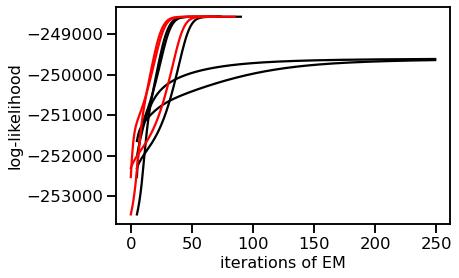

In [4]:
# Loading 
tempLl = np.load('../data_PWM/trainLl-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
tempP = np.load('../data_PWM/P-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
tempW = np.load('../data_PWM/W-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
fig, axes = plt.subplots(1)
bestInd, finalLl, topInd = find_top_init_plot_loglikelihoods(tempLl[0:5],maxdiff=100,ax=axes,startix=5,plot=True)
print(topInd)

In [14]:
print(tempP[4])
print(tempW[0].shape)

[[0.70204234 0.29795766]
 [0.53045031 0.46954969]]
(489249, 2, 6, 2)


[-0.6931767  -0.69335545 -0.6931767  -0.6931767  -0.69334558]
(5,)
[-0.50806529 -0.51019828 -0.50806529 -0.50806529 -0.51025322]


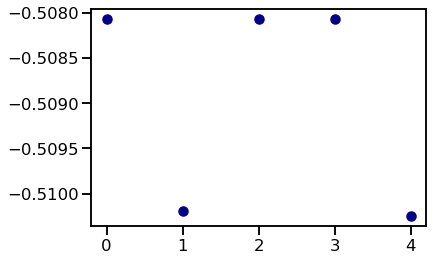

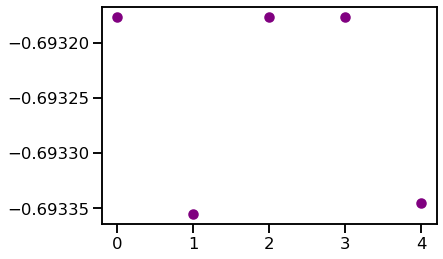

In [7]:
# Testing GLM-HMM initializations on test data
tempP = np.load('../data_PWM/P-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')
tempW = np.load('../data_PWM/W-global_PWM_all-animals_sf=4_2_state_multiple_inits_L2penaltyW=1.npy')

rat_id = 'W075'
path=laptop_path
fold = 0
stage_filter = 3
folds = 4
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)
D = trainX[0].shape[1]
C = 2 # only looking at binomial classes
K = 2
oldSessInd = [0, tempW[0].shape[0]]
testLlInit = np.zeros((5))
N = trainX[fold].shape[0]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)
# evaluate
for ind in range(0,5):
    sess = len(testSessInd[fold]) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(tempW[ind], oldSessInd, testSessInd[fold], True))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],tempP[ind],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
        testLlInit[ind] += temp

testLlInit = testLlInit / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset
print(testLlInit)
print(finalLl.shape)
trainLlInit = finalLl / tempW[0].shape[0]
print(trainLlInit)
fig, axes = plt.subplots(1)
axes.scatter(range(0,5), trainLlInit, color='darkblue',label='train')
fig, axes = plt.subplots(1)
axes.scatter(range(0,5), testLlInit, color='purple',label='test')


In [19]:
oldTrainLl = np.load('../data_PWM/trainLl_PWM_W075_sf=3_2_state_fold-0_multiple_sigmas_penaltyW=True.npy')
oldTestLl = np.load('../data_PWM/testLl_PWM_W075_sf=3_2_state_fold-0_multiple_sigmas_penaltyW=True.npy')
finalTrainLl = oldTrainLl[0]/trainSessInd[0][-1]
print(finalTrainLl[225])
print(oldTestLl[0])

-0.5397365941243673
-0.5462022811090963


In [11]:
oldP = np.load('../data_PWM/P_PWM_W075_sf=3_2_state_fold-0_multiple_sigmas_penaltyW=True.npy')
oldW = np.load('../data_PWM/W_PWM_W075_sf=3_2_state_fold-0_multiple_sigmas_penaltyW=True.npy')
oldLl = np.load('../data_PWM/W_PWM_W075_sf=3_2_state_fold-0_multiple_sigmas_penaltyW=True.npy')
print(oldP)
oldTrainLl = 0
oldTestLl = 0
sess = len(testSessInd[fold]) - 1 # number sessions
testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(oldW[0], oldSessInd, testSessInd[fold], True))
for s in range(0, sess):
    # evaluate on test data for each session separately
    _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],oldP[0],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
    testLlInit[ind] += temp

testLlInit = testLlInit / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset

(13, 2, 2)


In [ ]:
# Checking that parameters are consistent across top matching indices

# oneSessInd = np.arange(0, tempW[0].shape[0],300)
# for ind in topInd:
#     print(tempP[ind])
#     fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(26,11))
#     fig.suptitle(f'Weights for 4 animals with {K} states & sigma=0')
#     fig.tight_layout()
#     axes[0,0].set_ylim(-2.2,2.2)
#     axes[1,0].set_ylim(-2.2,2.2)
#     axes[0,1].set_ylim(-2.2,2.2)
#     axes[1,1].set_ylim(-2.2,2.2)
#     plotting_weights_PWM(w=tempW[ind], sessInd=oneSessInd, axes=axes, sessStop=None, title=f'Weights for 4 animals with {K} states & sigma=0', save_fig=False)


In [5]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4

# for randInd in randomOrder:
#     animal = animalsIDs[randInd]
for K in [2,1]:
    glmhmmP = np.load(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
    glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
    print(glmhmmW.shape)
    for animal in ['W075','W081','W060']:
        print("Animal ", animal)
        trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id=animal, stage_filter=3, K=K, folds=nfolds, sigmaList = sigmaList, maxiter=300, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=1, path=pni_path, save=True)


(489249, 2, 6, 2)
Animal  W075
Sigma Index 0
GLM HMM BEST INIT
Sigma Index 1
0
100


In [5]:
print(tempW[bestInd].shape)

(489249, 2, 6, 2)


In [7]:
# Fitting multiple init from optimal GLM-HMM sol initializations + noise to sigma=0.1 directly

rat_id = 'W075'
inits = 5
stage_filter = 3
folds = 4
fold = 0
L2penaltyW=1
maxiter = 300

path = laptop_path
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=folds, random_state=1)

D = trainX[0].shape[1]
C = 2 # only looking at binomial classes
K = 2

glmhmmP = np.load(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')[bestInd]
oldSessInd = [0, glmhmmW.shape[0]]
N = trainX[fold].shape[0]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
trainY[fold] = trainY[fold].astype(int)
testY[fold] = testY[fold].astype(int)

allP = np.zeros((inits, K, K))
allW = np.zeros((inits, N, K, D, C))
allLl = np.zeros((inits, maxiter))
testLl = np.zeros((inits))

for i in range(0,inits):
    print("Init ", i)
    noiseP0, noiseW0 = dGLM_HMM.generate_param(sessInd=trainSessInd[fold], transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-1,1)]) # initial random param
    # two different ways of intializing P 
    if (i==0):
        initP = glmhmmP
        initW = reshapeWeights(glmhmmW, oldSessInd, trainSessInd[fold], standardGLMHMM=True)
    elif (i%2 == 0):
        initP = (noiseP0 + glmhmmP) / 2
        initW = noiseW0/2 + reshapeWeights(glmhmmW, oldSessInd, trainSessInd[fold], standardGLMHMM=True)
    else:
        initP = noiseP0
        initW = noiseW0 + reshapeWeights(glmhmmW, oldSessInd, trainSessInd[fold], standardGLMHMM=True)
    print(initP)
    allP[i], allW[i], allLl[i] = dGLM_HMM.fit(trainX[fold], trainY[fold],  initP, initW, sigma=reshapeSigma(0.1, K, D), sessInd=trainSessInd[fold], pi0=None, maxIter=maxiter, tol=1e-3, L2penaltyW=L2penaltyW) # fit the model
        
    # evaluate
    sess = len(trainSessInd[fold]) - 1 # number sessions
    testPhi = dGLM_HMM.observation_probability(testX[fold], reshapeWeights(allW[i], trainSessInd[fold], testSessInd[fold]))
    for s in range(0, sess):
        # evaluate on test data for each session separately
        _, _, temp = dGLM_HMM.forward_pass(testY[fold][testSessInd[fold][s]:testSessInd[fold][s+1]],allP[i],testPhi[testSessInd[fold][s]:testSessInd[fold][s+1]])
        testLl[i] += temp
    
    testLl[i] = testLl[i] / testSessInd[fold][-1] # normalizing to the total number of trials in test dataset

    np.save(f'../data_PWM/trainLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_sigma=0.1_L2penaltyW={L2penaltyW}', allLl)
    np.save(f'../data_PWM/testLl_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_sigma=0.1_L2penaltyW={L2penaltyW}', testLl)
    np.save(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_sigma=0.1_L2penaltyW={L2penaltyW}', allP)
    np.save(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_inits_sigma=0.1_L2penaltyW={L2penaltyW}', allW)


Init  0
[[0.99851448 0.00148552]
 [0.00140886 0.99859114]]
0
100
200
Init  1
[[0.9591162 0.0408838]
 [0.1064932 0.8935068]]
0
100
200
Init  2
[[0.90833883 0.09166117]
 [0.18396508 0.81603492]]
0
100
200
Init  3
[[0.85796819 0.14203181]
 [0.09172459 0.90827541]]
0
100
200
Init  4
[[0.8629581  0.1370419 ]
 [0.11268864 0.88731136]]
0


### Fitting mulitple initializations at the global fit first (sigma=0) - in PWM_GLM-HMM script

### Fitting dGLM-HMM1 for PWM data with K=1,2 and multiple sigmas value

In [48]:
randomOrder = np.array([6, 1, 9, 4, 5, 0, 7, 8, 3, 2])
print(randomOrder) # [6 1 9 4 5 0 7 8 3 2]

[6 1 9 4 5 0 7 8 3 2]


In [50]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4

# for randInd in randomOrder:
#     animal = animalsIDs[randInd]
for K in [2,1]:
    for animal in ['W075','W081','W060']:
        print("Animal ", animal)
        glmhmmP = np.load(f'../data_PWM/P-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
        glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
        print(glmhmmW.shape)
        # trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id=animal, stage_filter=3, K=K, folds=nfolds, sigmaList = sigmaList, maxiter=300, glmhmmW=glmhmmW, glmhmmP=glmhmmP, L2penaltyW=1, path=pni_path, save=True)

# new version of obs prob takes ... to fit 

Animal  W075
(12, 489249, 2, 6, 2)
Animal  W081
(12, 489249, 2, 6, 2)
Animal  W060
(12, 489249, 2, 6, 2)
Animal  W075
(20, 489249, 1, 6, 2)
Animal  W081
(20, 489249, 1, 6, 2)
Animal  W060
(20, 489249, 1, 6, 2)


In [24]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
nfolds = 4
trainLl, testLl, allP, allW = fit_eval_CV_multiple_sigmas_PWM(rat_id='W089', stage_filter=3, K=3, folds=nfolds, sigmaList = sigmaList, maxiter=300, penaltyW=True, path=laptop_path, save=True)


Sigma Index 0
0
100
200
Sigma Index 1
0
100
200
Sigma Index 2
0
100


KeyboardInterrupt: 

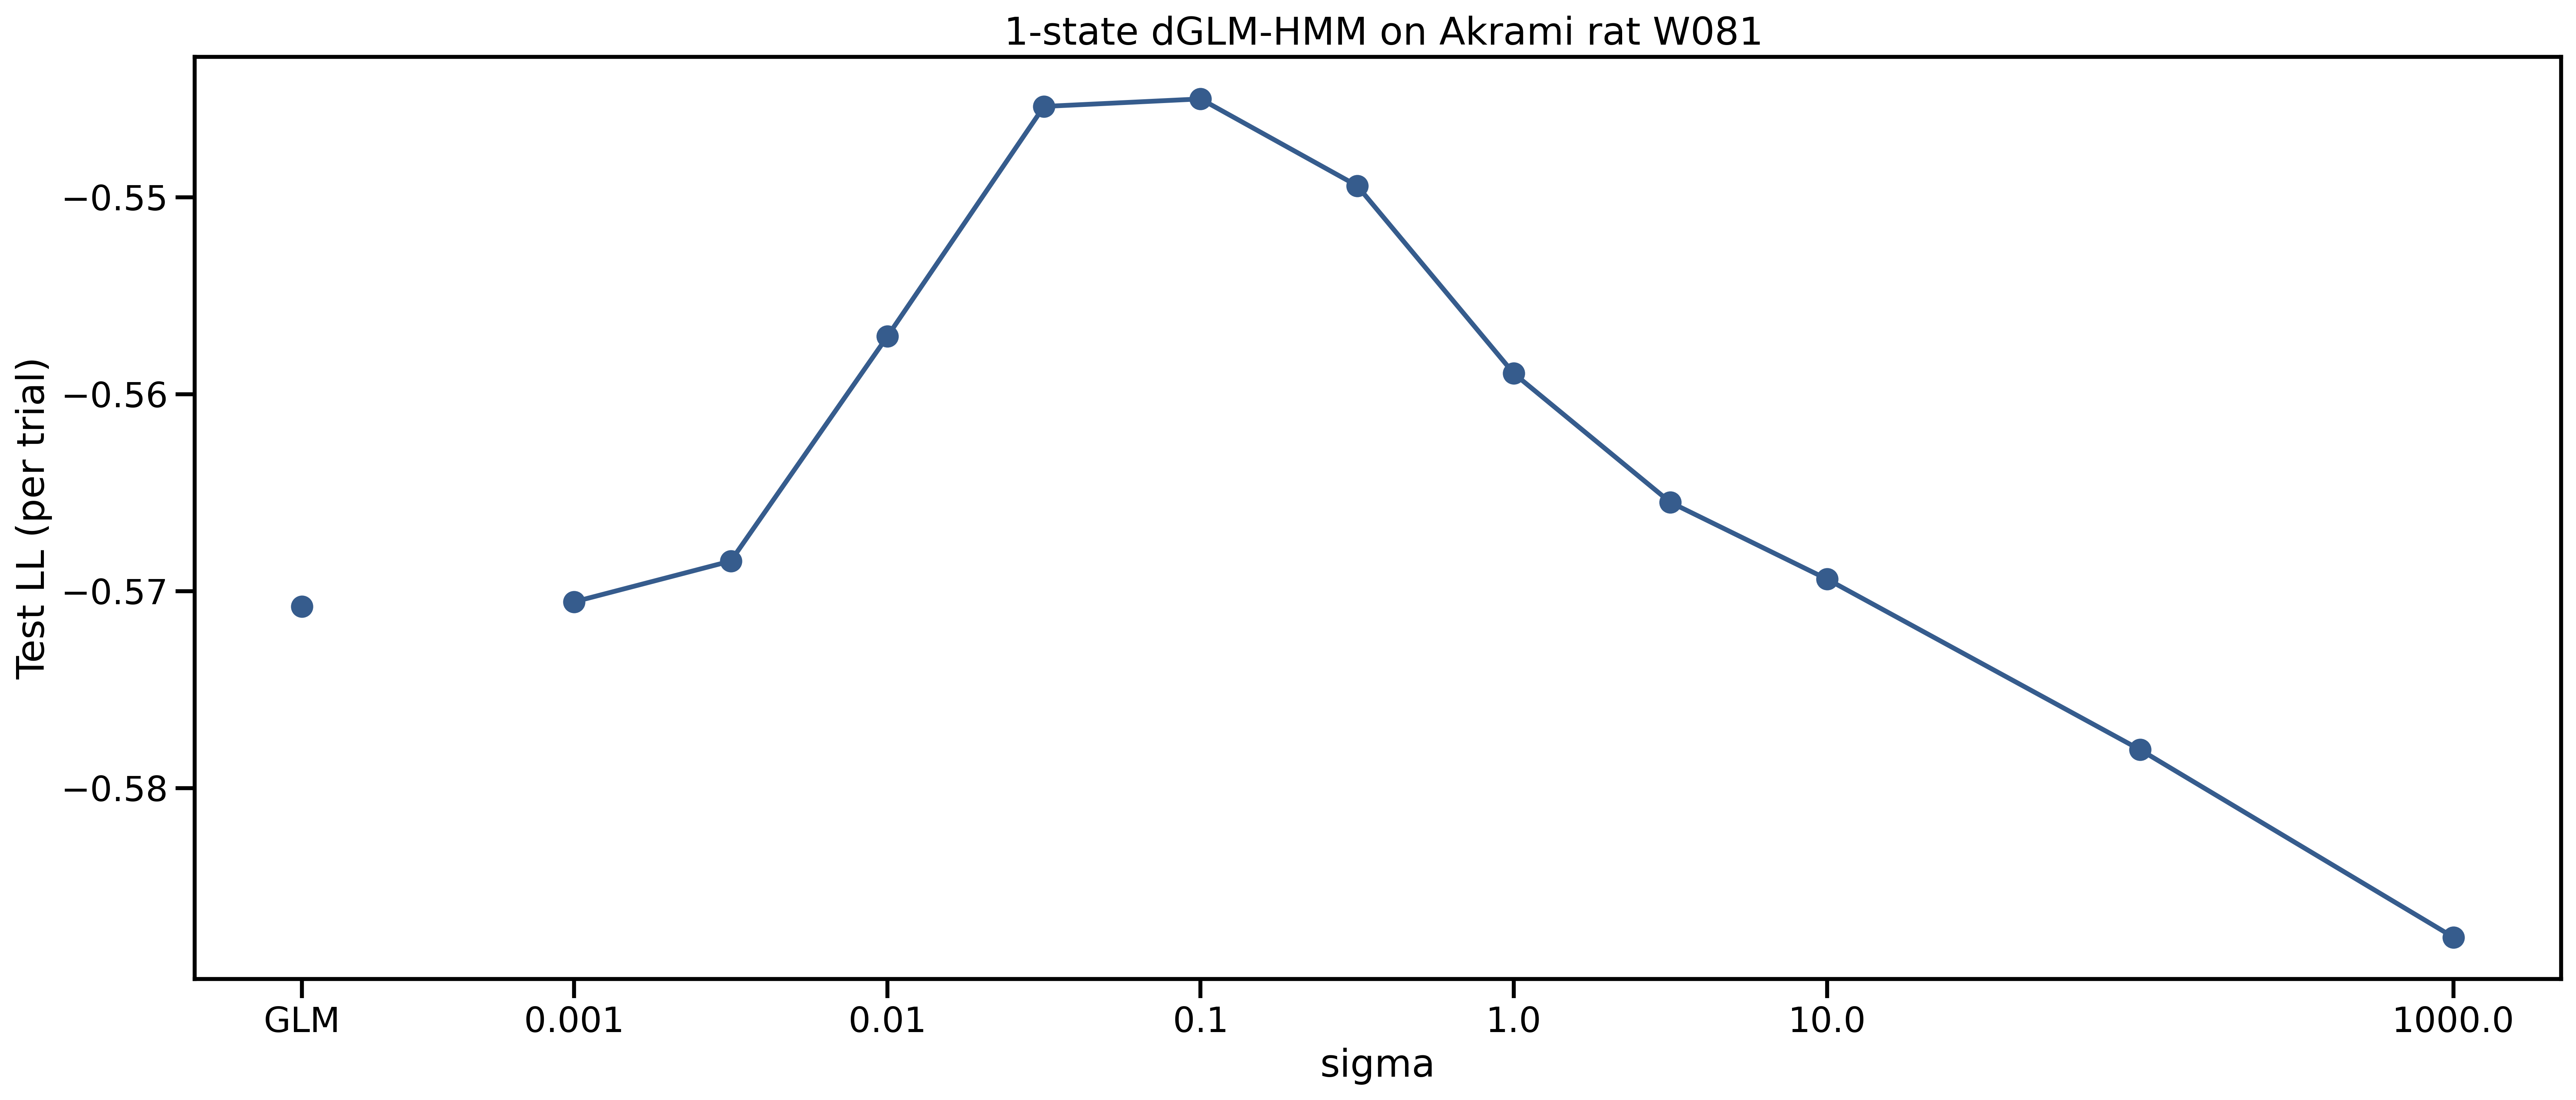

In [6]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))] 
nfolds = 4
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f' 1-state dGLM-HMM on Akrami rat W081', save_fig=True)

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will

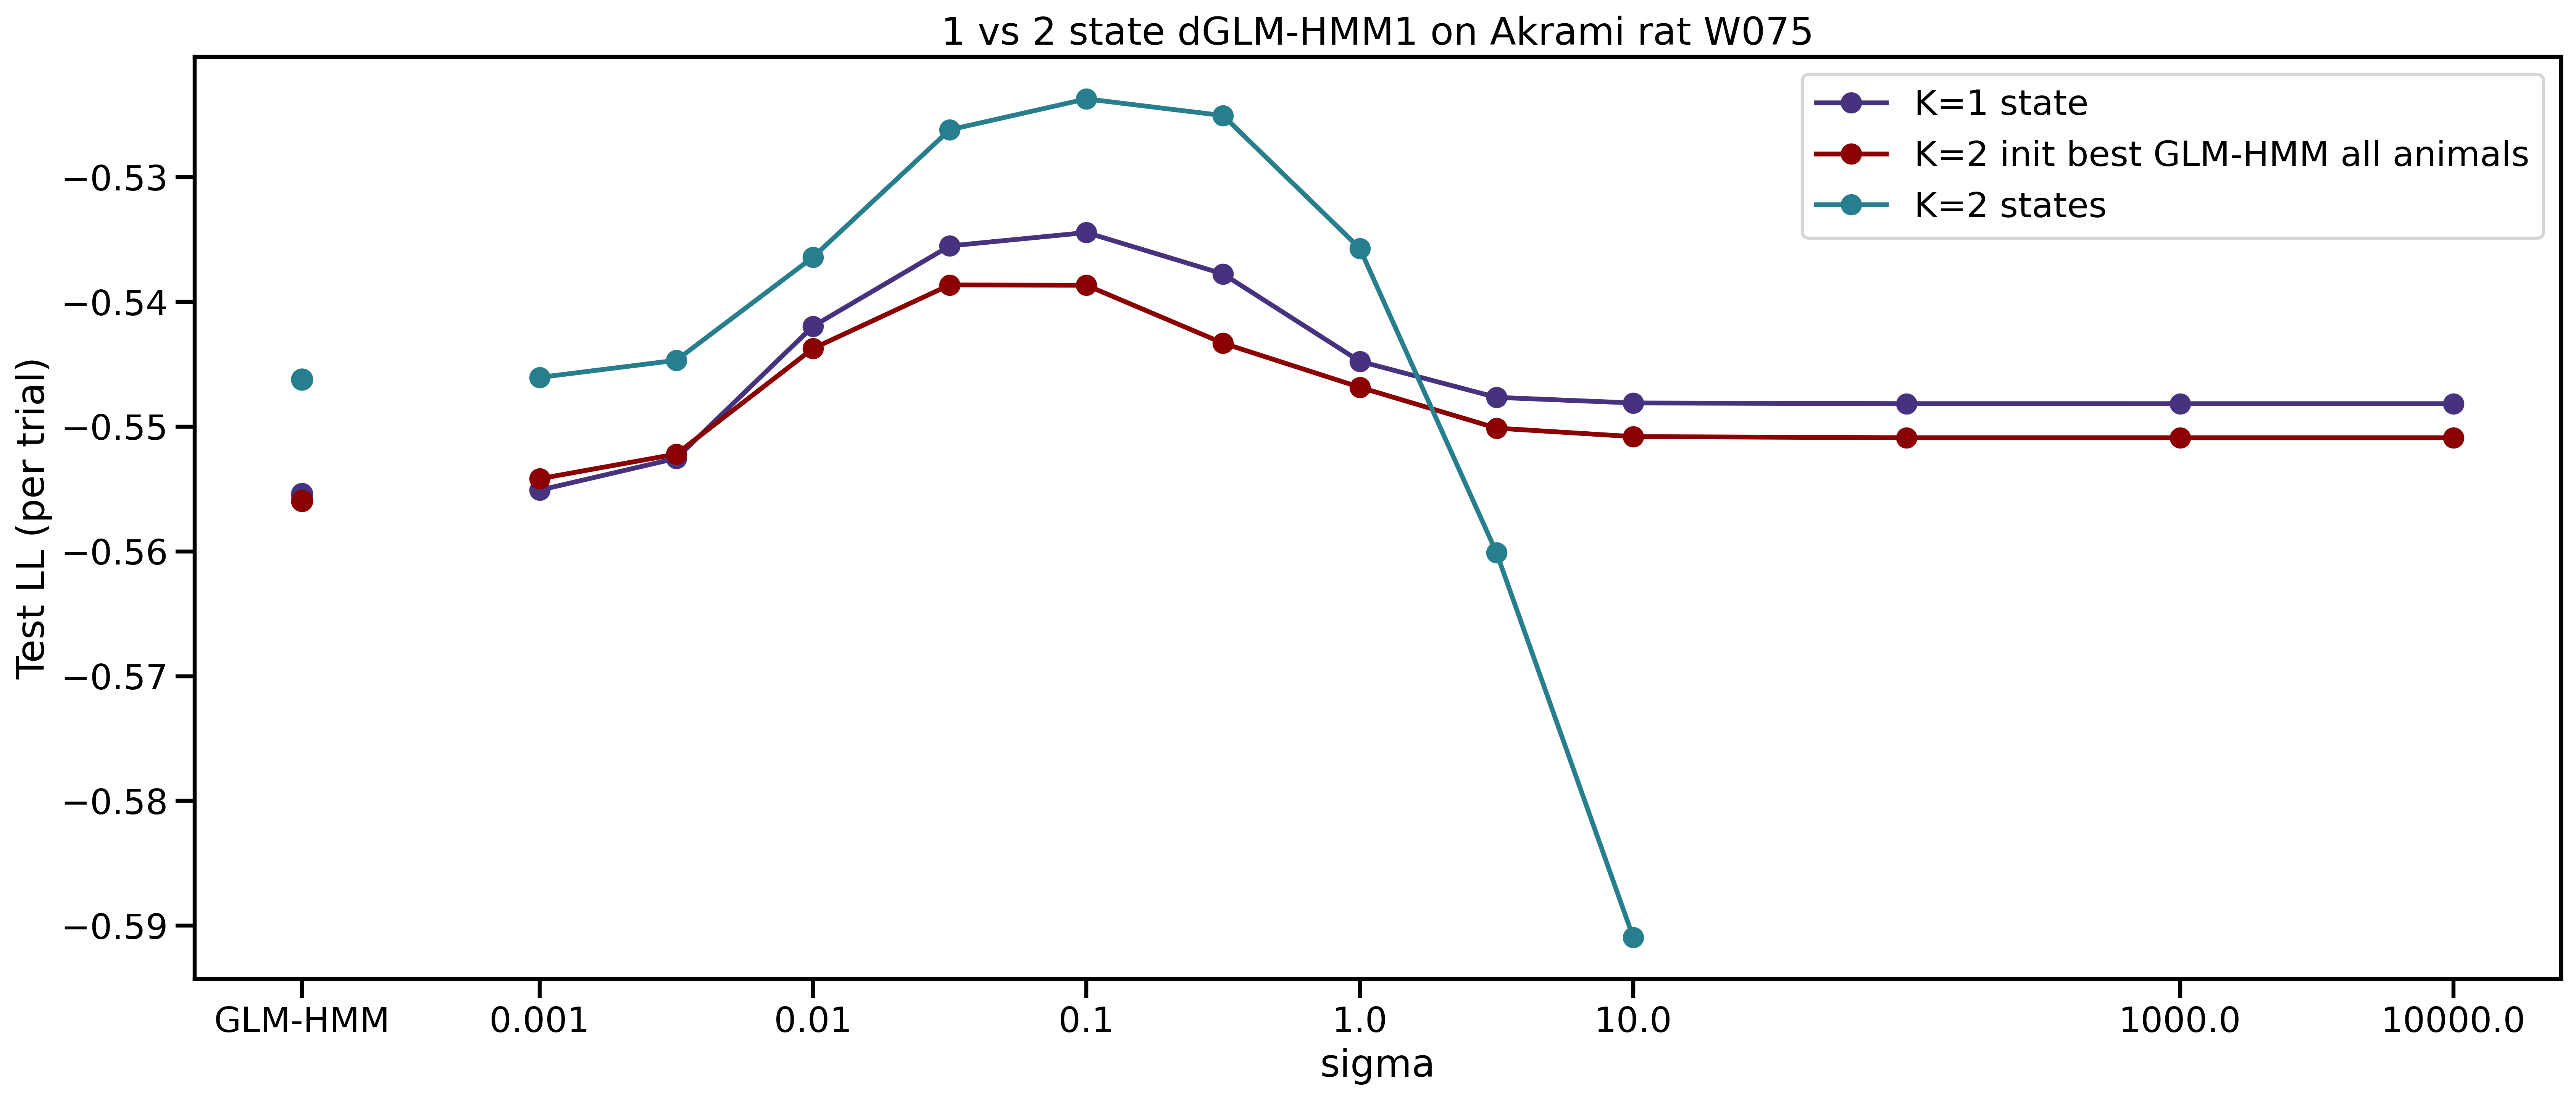

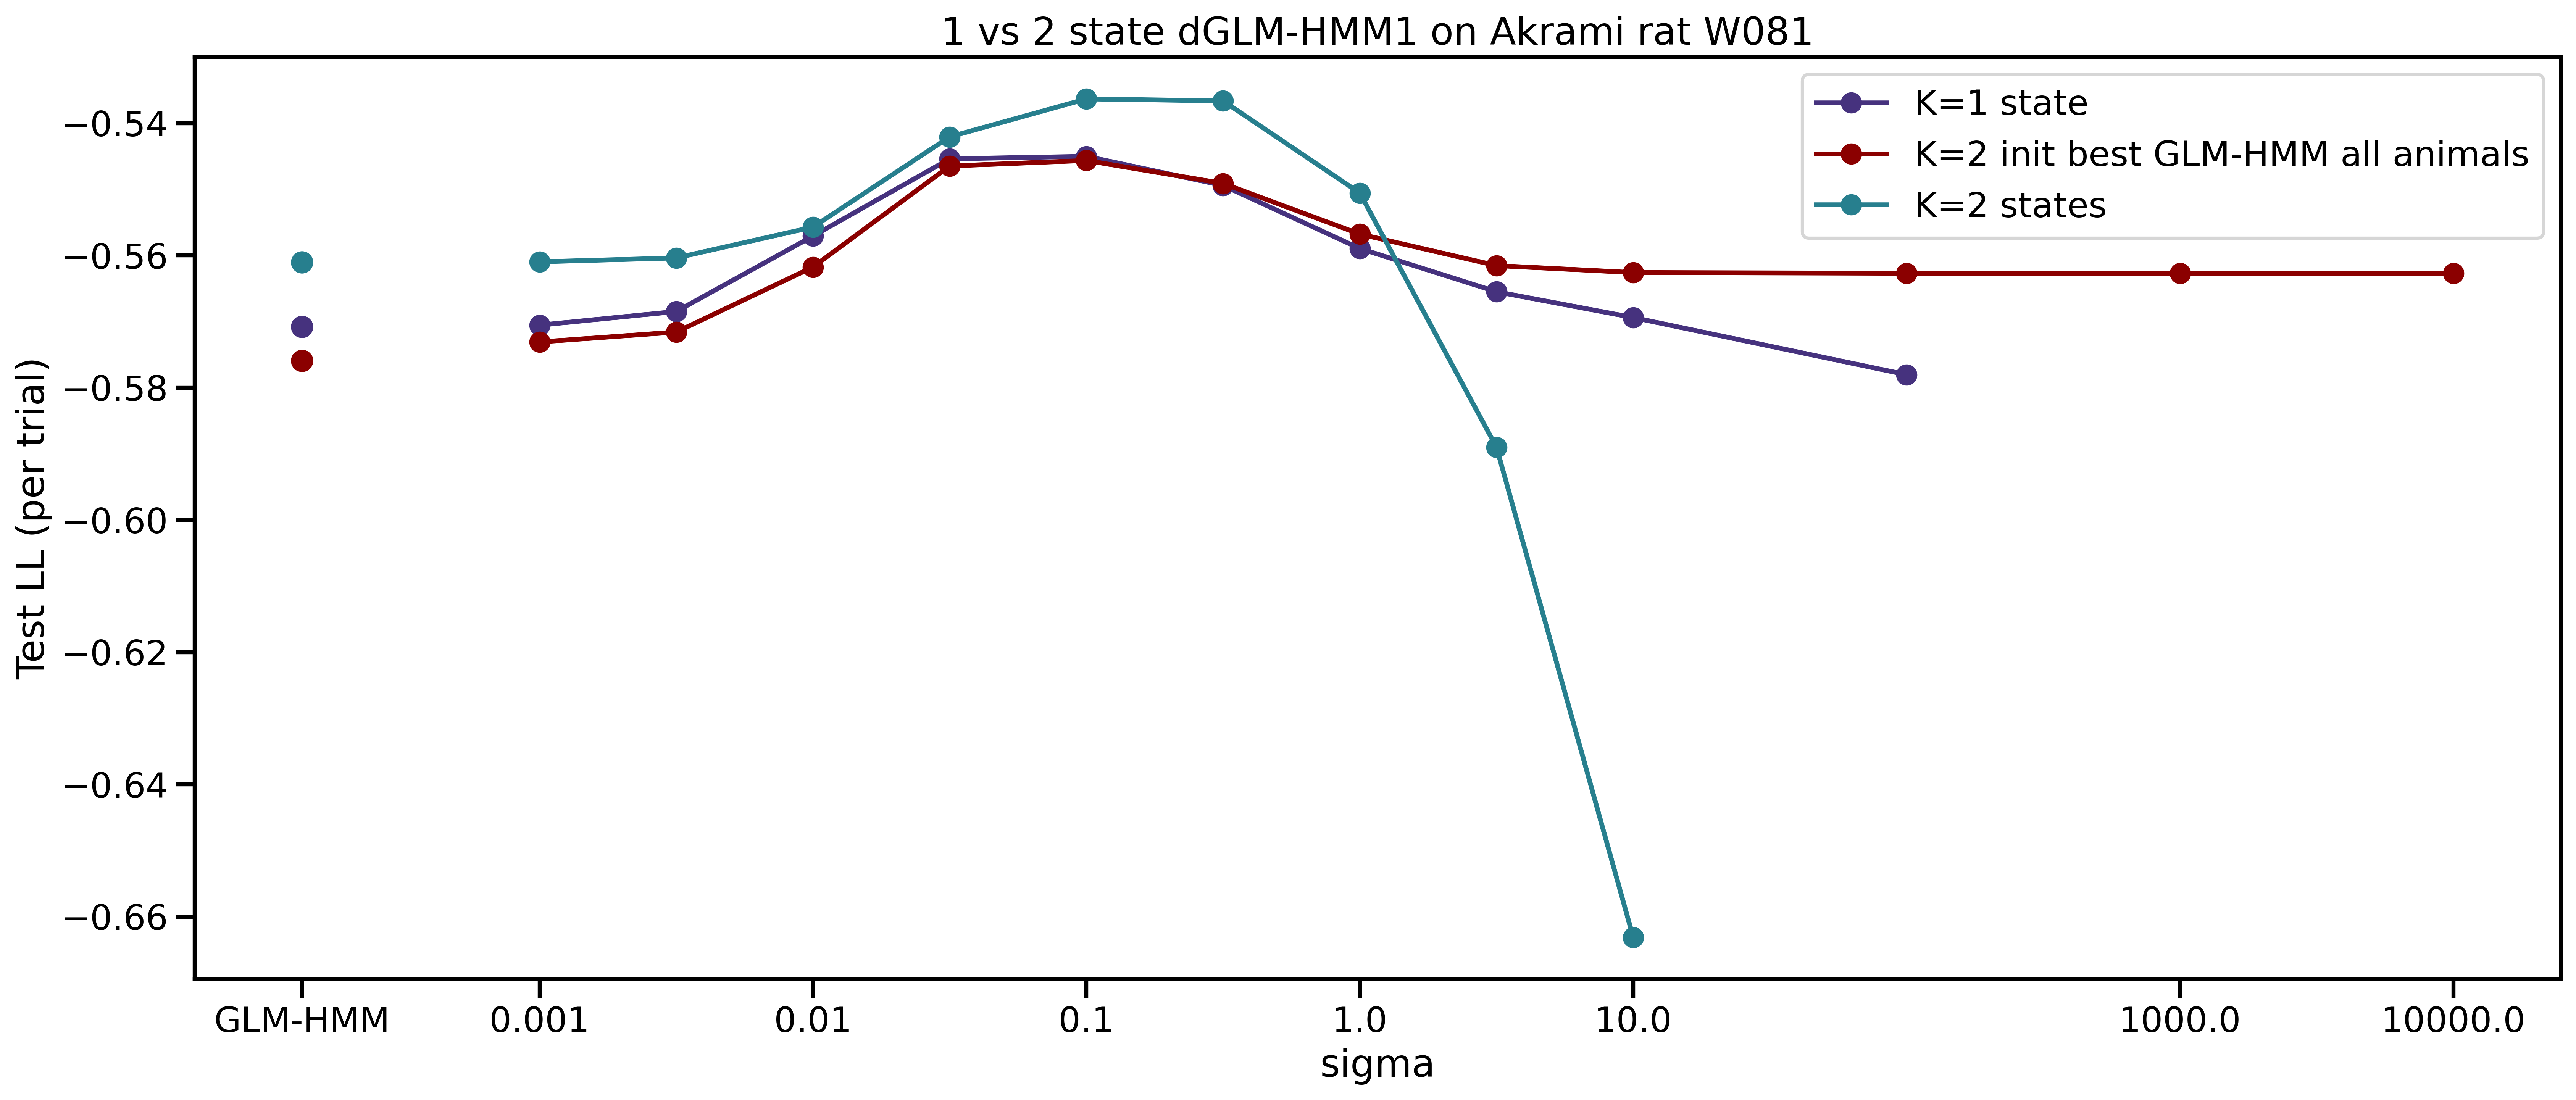

In [49]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# 1 vs 2 state test LL vs sigma for all animals
for animal in ['W075','W081']:#animalsCurrent:
    fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
    sigma_CV_testLl_plot_PWM(rat_id=animal, stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat {animal}', labels=['K=1 state'], color=0, penaltyW=True, save_fig=False)
    testLl = np.load(f'../data_PWM/testLl_PWM_{animal}_sf=3_2_state_fold-0_multiple_sigmas_L2penaltyW=1.npy')
    axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color='darkred', label='K=2 init best GLM-HMM all animals')
    axes.scatter(-2 + np.log(sigmaList[1]), testLl[0], color='darkred')
    sigma_CV_testLl_plot_PWM(rat_id=animal, stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat {animal}', labels=['K=2 states'], color=2, penaltyW=True, save_fig=True)

In [43]:
rat_id = animal
path = laptop_path
stage_filter=3
# Wnew = np.load(f'../data_PWM/W_PWM_{animal}_sf=3_1_state_fold-0_multiple_sigmas_L2penaltyW=1.npy')
# P = np.load(f'../data_PWM/P_PWM_{animal}_sf=3_1_state_fold-0_multiple_sigmas_L2penaltyW=1.npy')
# print(Wnew[0,200,:,:,1])
fold = 0
x, y = io_utils.prepare_design_matrices(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter, overwrite=False)
sessInd = list(io_utils.session_start(rat_id=rat_id, path=path, psychometric=True, cutoff=10, stage_filter=stage_filter)) 
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=4, random_state=1)
N = trainX[fold].shape[0]
oldSessInd = [0,glmhmmW.shape[0]]
w = reshapeWeights(glmhmmW, oldSessInd, trainSessInd[fold], standardGLMHMM=True)

ValueError: could not broadcast input array from shape (489249,1,2) into shape (48,489249,1)

(13, 100835, 2, 6, 2)
78129


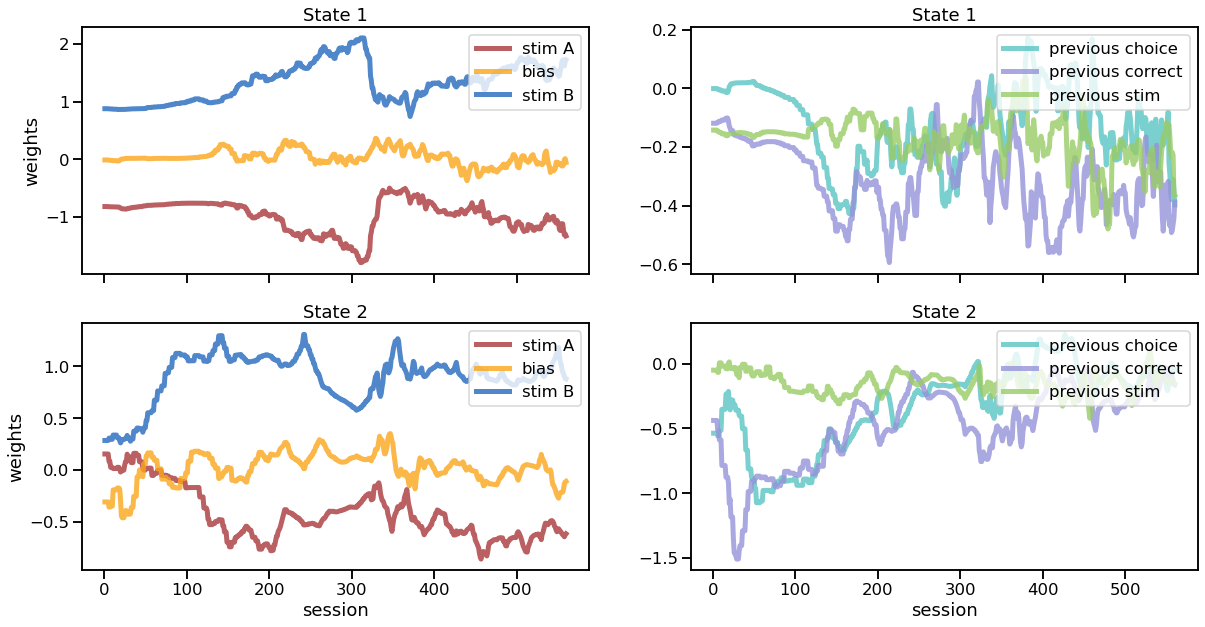

In [70]:
rat_id='W081'
K=2
W = np.load(f'../data_PWM/W_PWM_W075_sf=3_{K}_state_fold-0_multiple_sigmas_L2penaltyW=1.npy')
print(W.shape)
trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
print(trainSessInd[-1])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(20,10))
plotting_weights_PWM(w=W[5], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma=0', save_fig=False)

(20, 489249, 1, 6, 2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

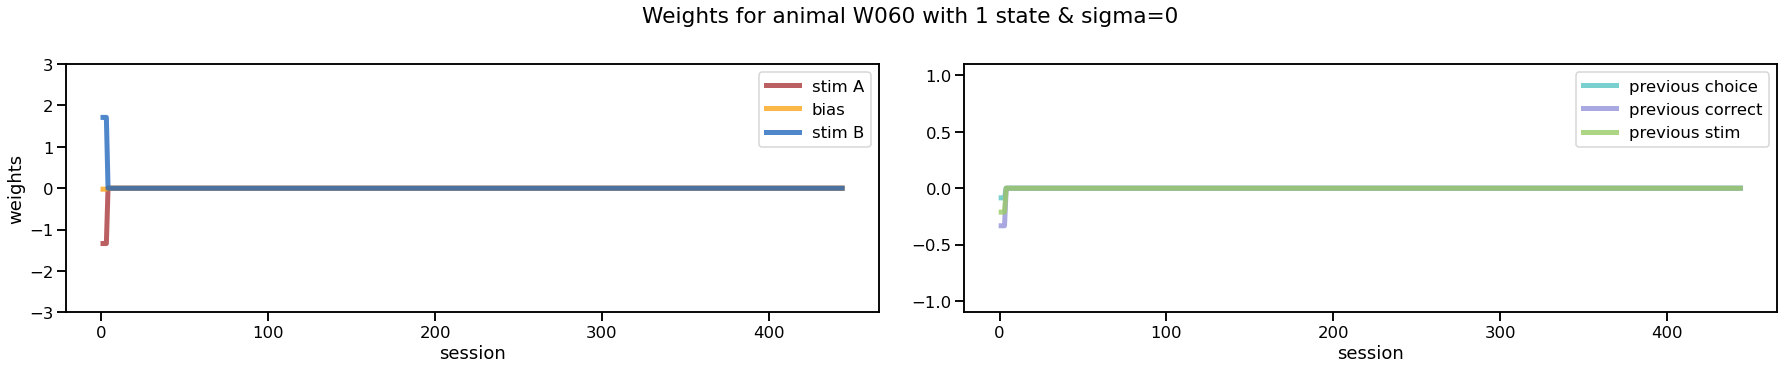

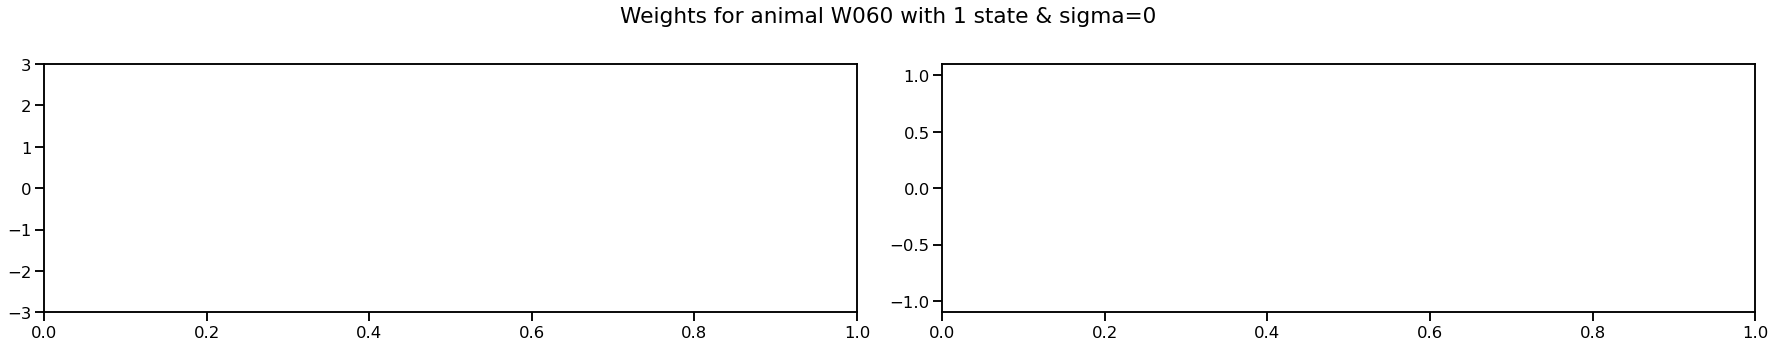

In [51]:
rat_id = animal
K = 1
# glmhmmW = np.load(f'../data_PWM/W-global_PWM_all-animals_sf=4_{K}_state_multiple_inits_L2penaltyW=1.npy')
# print(glmhmmW.shape)
# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(25,5))
# axes[0].set_ylim(-3,3)
# axes[1].set_ylim(-1.1,1.1)
# fig.suptitle(f'Weights for animal {rat_id} with {K} state & sigma=0')
# fig.tight_layout()
trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf=3_{K}_state_fold-0_multiple_sigmas_penaltyW=True.npy')
plotting_weights_PWM(w=Wnew[0], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma=0', save_fig=False)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(25,5))
axes[0].set_ylim(-3,3)
axes[1].set_ylim(-1.1,1.1)
fig.suptitle(f'Weights for animal {rat_id} with {K} state & sigma=0')
fig.tight_layout()
plotting_weights_PWM(w=glmhmmW, sessInd=oldSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma=0', save_fig=False)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(25,5))
axes[0].set_ylim(-3,3)
axes[1].set_ylim(-1.1,1.1)
fig.suptitle(f'Weights for animal {rat_id} with {K} state & sigma=0')
fig.tight_layout()
plotting_weights_PWM(w=W[0], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma=0', save_fig=False)
       

/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(np.log(sigmaList[1:]), testLl[1:], '-o', color=colormap[color+fold], linestyle=linestyle, label=labels[fold])
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/plotting_utils.py:137: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will

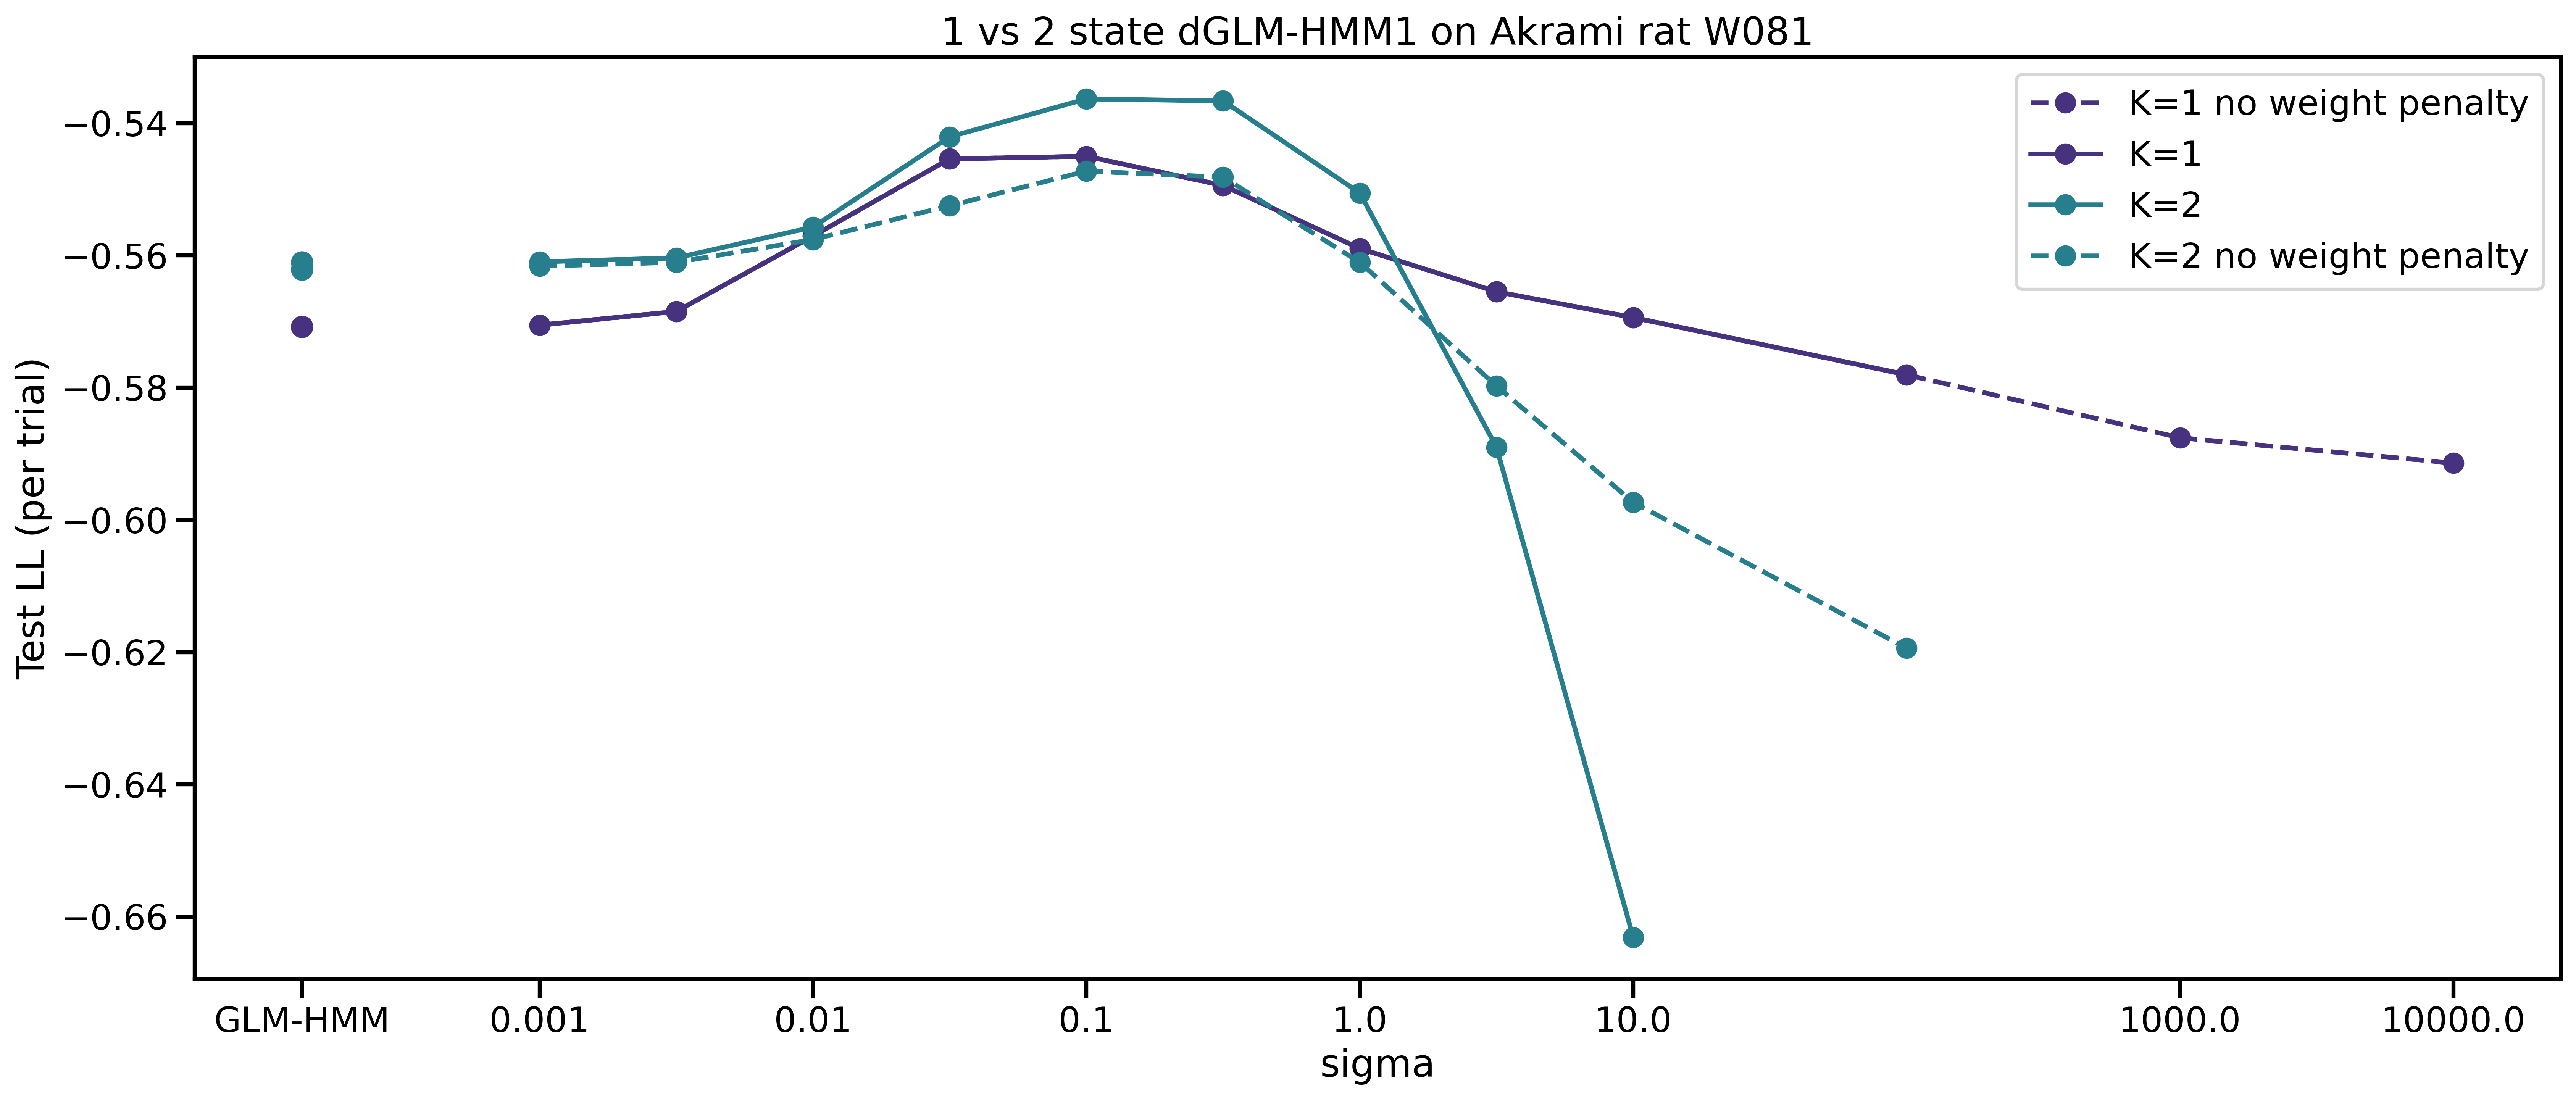

In [6]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=1 no weight penalty'], color=0, linestyle='dashed', penaltyW=False, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=2'], color=2, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 state dGLM-HMM1 on Akrami rat W081', labels=['K=2 no weight penalty'], color=2, linestyle='dashed', penaltyW=False, save_fig=True)

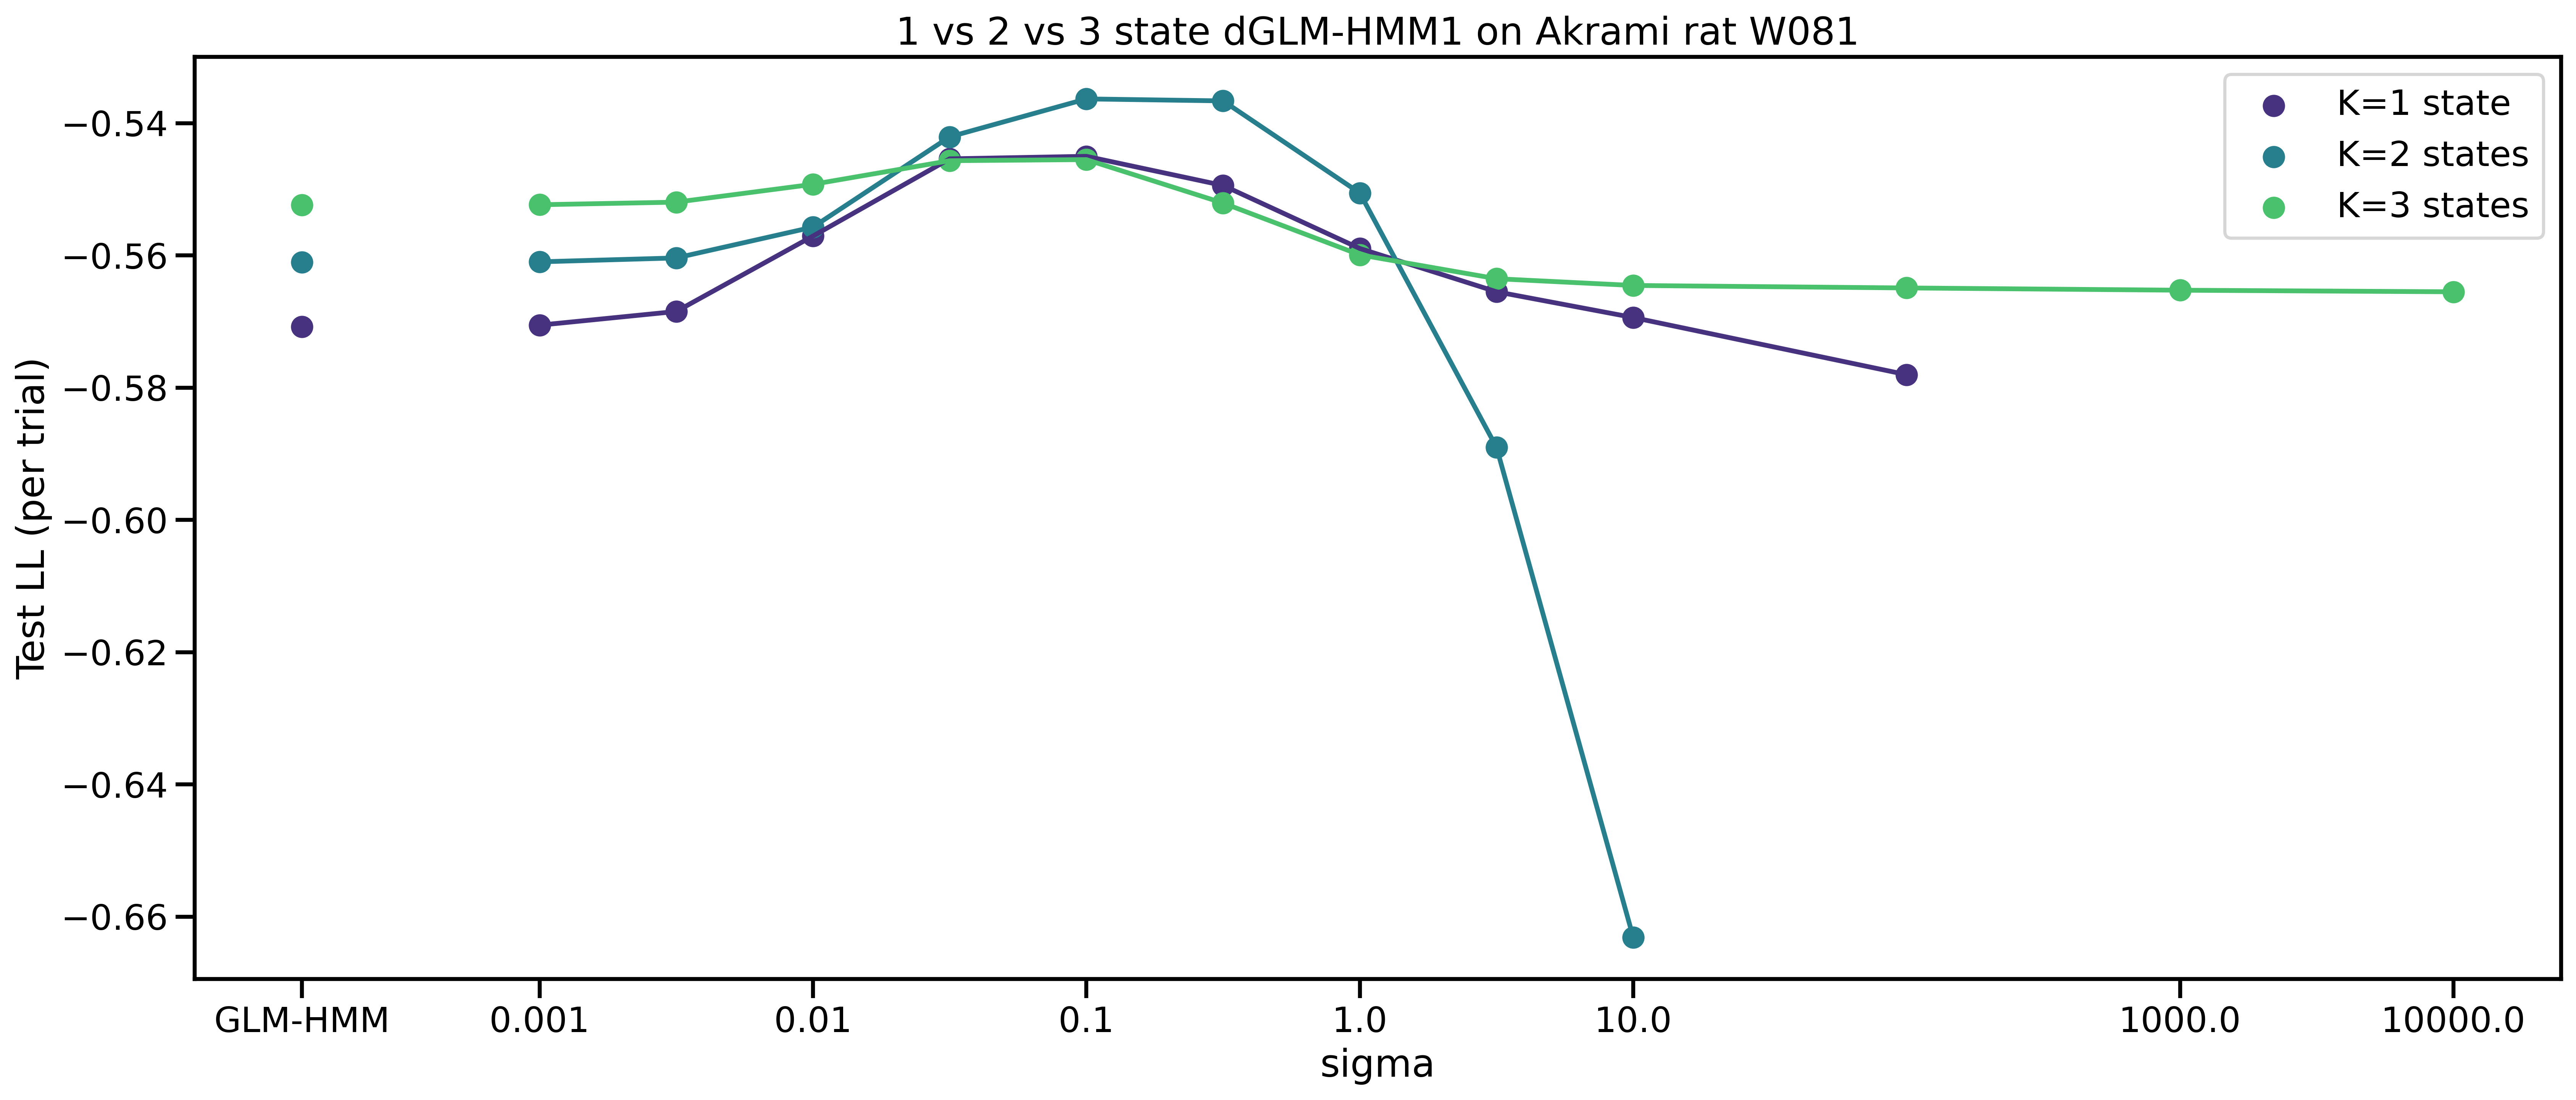

In [32]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=1 state'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=2 states'], color=2, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W081', stage_filter=3, K=3, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 vs 3 state dGLM-HMM1 on Akrami rat W081', labels=['K=3 states'], color=4, penaltyW=True, save_fig=True)

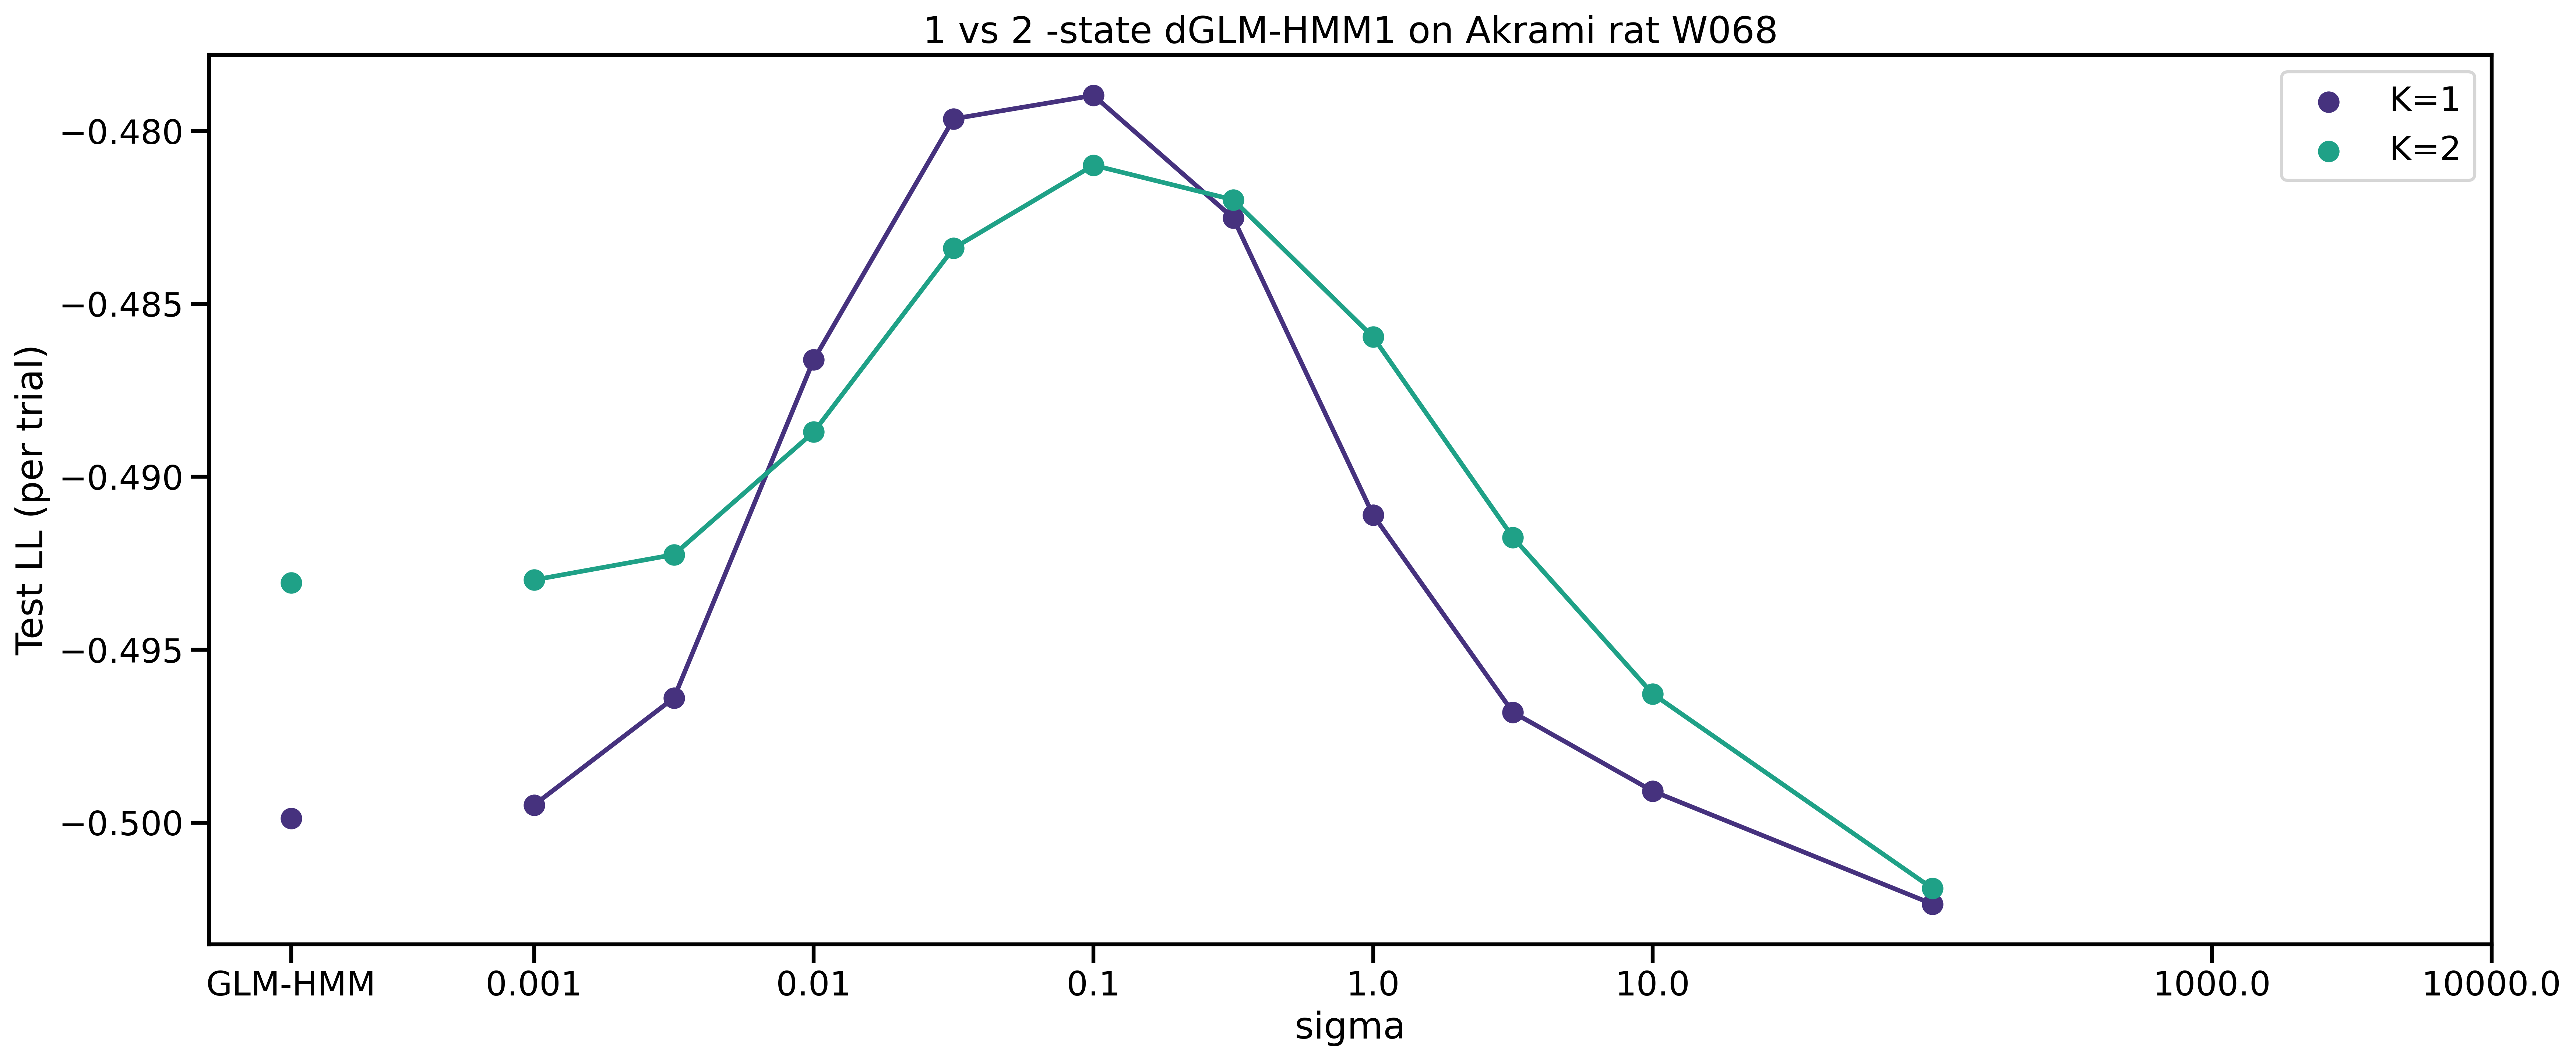

In [29]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W068', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W068', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W068', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W068', labels=['K=2'], color=3, penaltyW=True, save_fig=False)

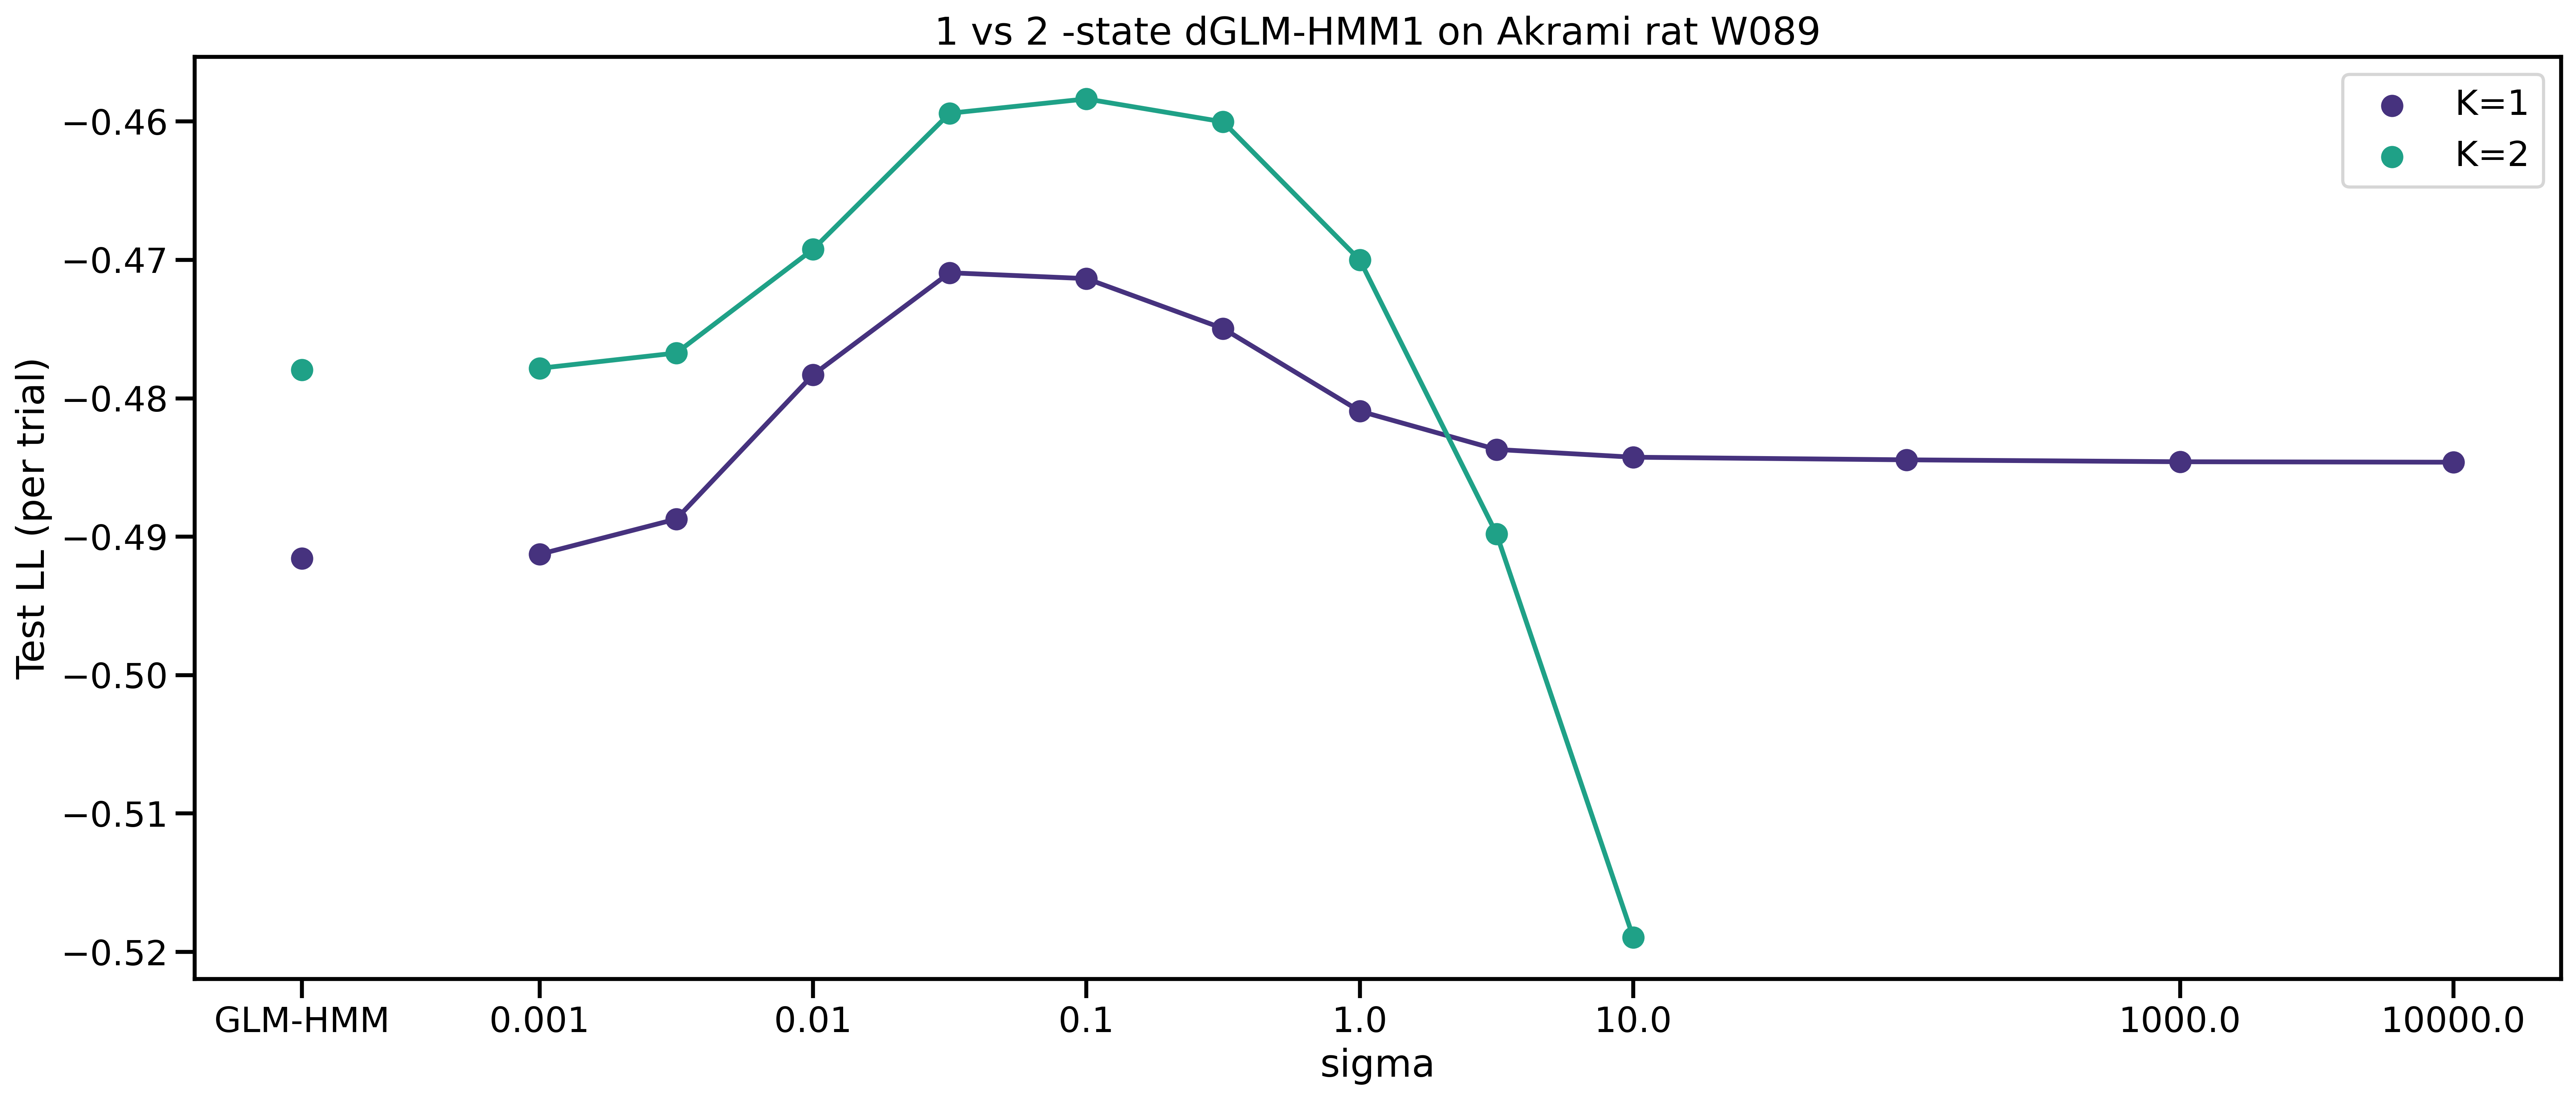

In [30]:
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
sigma_CV_testLl_plot_PWM(rat_id='W089', stage_filter=3, K=1, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W089', labels=['K=1'], color=0, penaltyW=True, save_fig=False)
sigma_CV_testLl_plot_PWM(rat_id='W089', stage_filter=3, K=2, folds=1, sigmaList=sigmaList, axes=axes, title=f'1 vs 2 -state dGLM-HMM1 on Akrami rat W089', labels=['K=2'], color=3, penaltyW=True, save_fig=False)

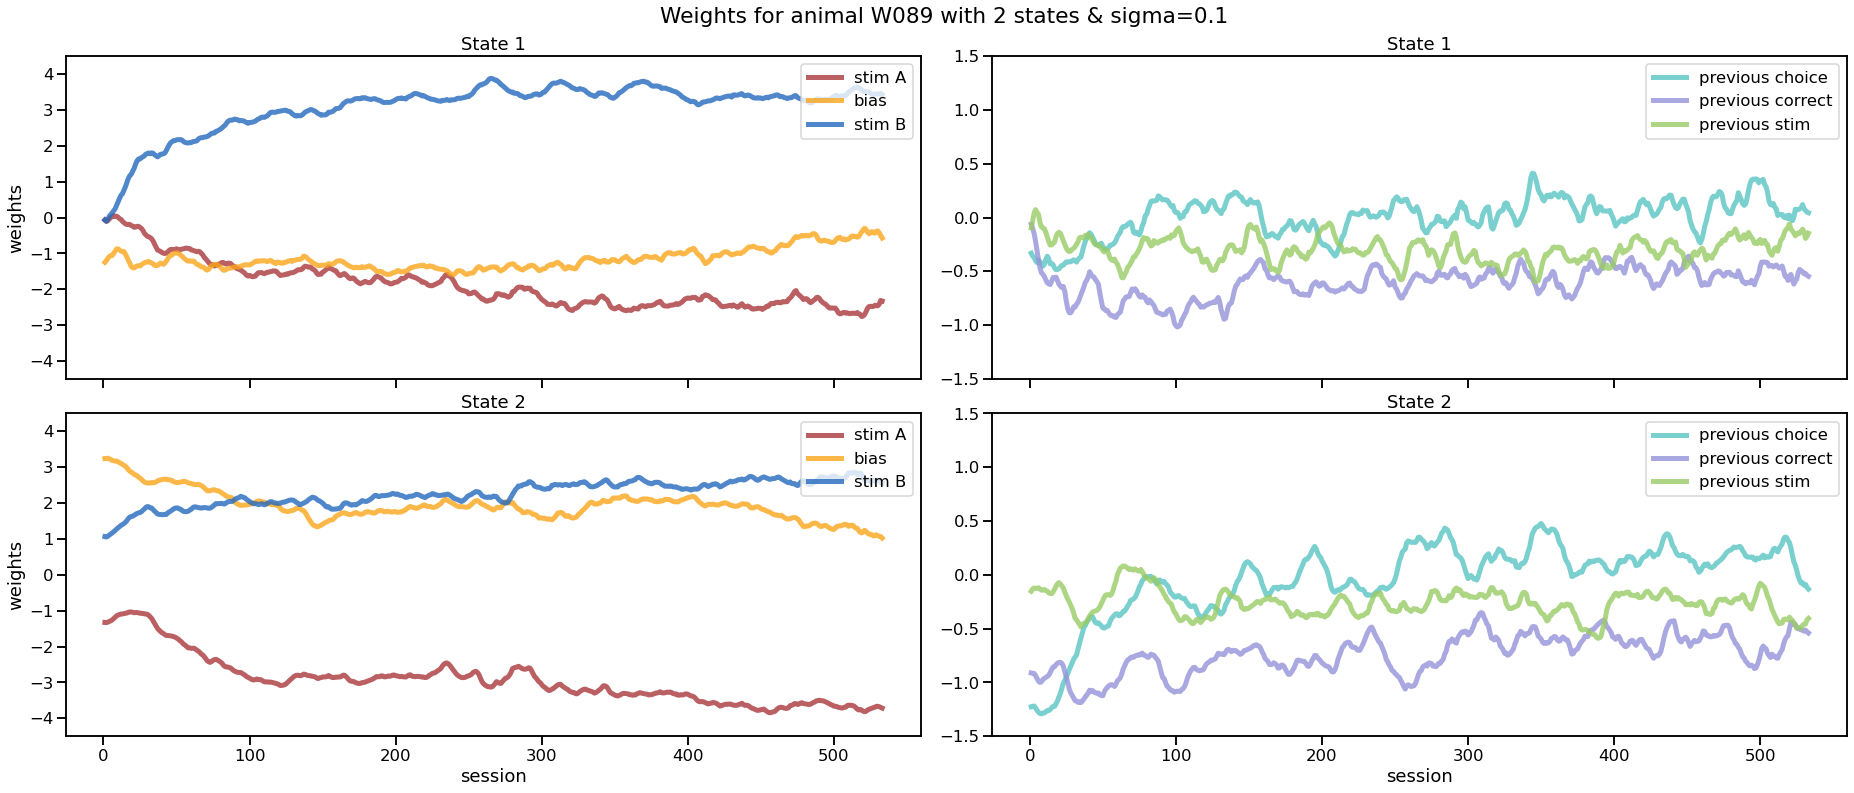

In [59]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(26,11))
    fig.suptitle(f'Weights for animal {rat_id} with {K} states & sigma={np.round(sigmaList[indSigma],4)}')
    fig.tight_layout()
    axes[0,0].set_ylim(-4.5,4.5)
    axes[1,0].set_ylim(-4.5,4.5)
    axes[0,1].set_ylim(-1.5,1.5)
    axes[1,1].set_ylim(-1.5,1.5)
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} states & sigma={np.round(sigmaList[indSigma],4)}', save_fig=True)

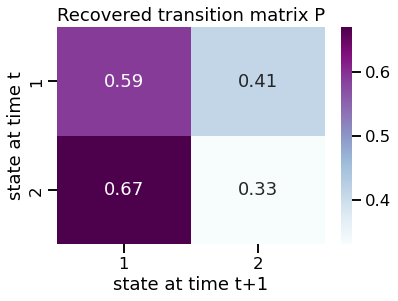

In [60]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING Transition matrix P
for fold in range(0,1):
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    s = sns.heatmap(np.round(allP[indSigma],2),annot=True,cmap='BuPu', fmt='g')
    s.set(xlabel='state at time t+1', ylabel='state at time t', title='Recovered transition matrix P', xticklabels=[1,2], yticklabels=[1,2])
    fig = s.get_figure()
    

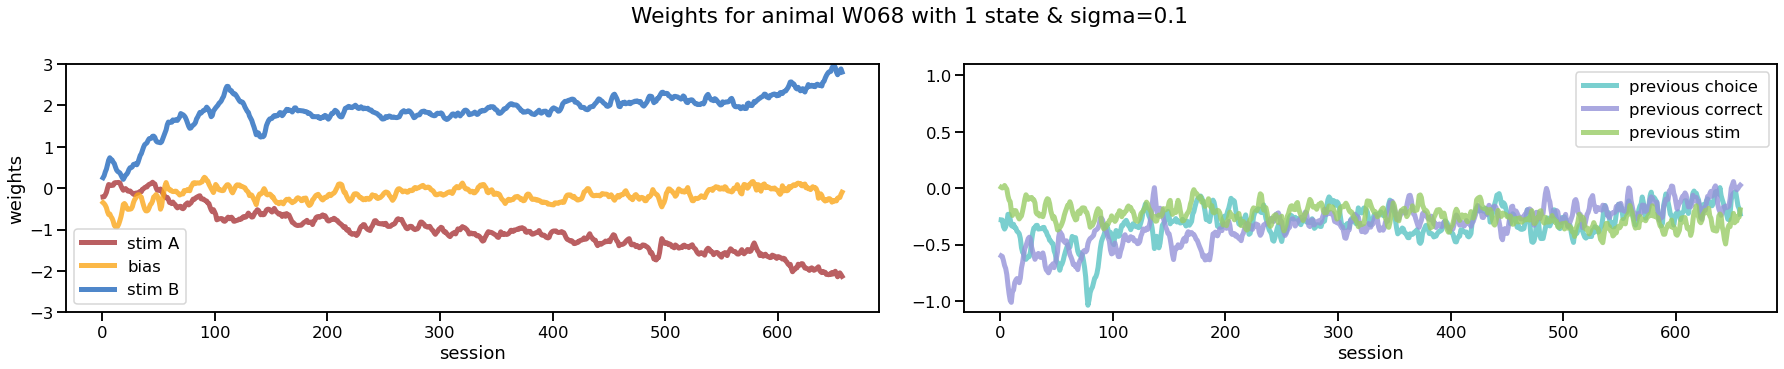

In [29]:
rat_id = 'W068'
stage_filter = 3
folds = 4
K = 1
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    testSessInd = np.load(f'../data_PWM/testSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(25,5))
    axes[0].set_ylim(-3,3)
    axes[1].set_ylim(-1.1,1.1)
    fig.suptitle(f'Weights for animal {rat_id} with {K} state & sigma={np.round(sigmaList[indSigma],4)}')
    fig.tight_layout()
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=None, title=f'Weights for animal {rat_id} with {K} state & sigma={np.round(sigmaList[indSigma],4)}', save_fig=True)
       

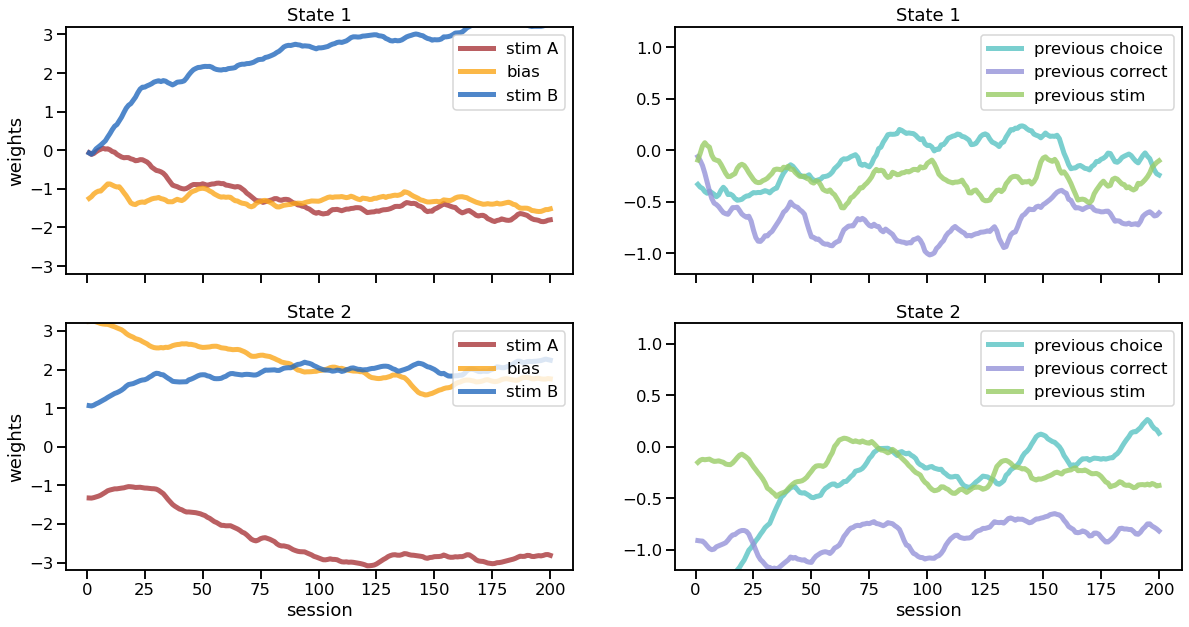

In [20]:
rat_id = 'W089'
stage_filter = 3
folds = 4
K = 2
penaltyW = True
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,5,1,dtype=float))] 
# PLOTTING WEIGHTS ACROSS MULTIPLE SIGMAS
for fold in range(0,1):
    trainSessInd = np.load(f'../data_PWM/trainSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    testSessInd = np.load(f'../data_PWM/testSessInd_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allP = np.load(f'../data_PWM/P_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    allW = np.load(f'../data_PWM/W_PWM_{rat_id}_sf={stage_filter}_{K}_state_fold-{fold}_multiple_sigmas_penaltyW={penaltyW}.npy')
    indSigma = 5
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(20,10))
    axes[0,0].set_ylim(-3.2,3.2)
    axes[1,0].set_ylim(-3.2,3.2)
    axes[0,1].set_ylim(-1.2,1.2)
    axes[1,1].set_ylim(-1.2,1.2)
    plotting_weights_PWM(w=allW[indSigma], sessInd=trainSessInd, axes=axes, sessStop=200, title=f'PWM {rat_id} - {K} state, sigma={np.round(sigmaList[indSigma],4)}', save_fig=False)
       